<a href="https://colab.research.google.com/github/kwazinhlaka/2022-pydata-global-seaborn/blob/main/Visually_Inspecting_Data_Profiles_for_Data_Distribution_Shifts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visually Inspecting Data Profiles for Data Distribution Shifts

The real world is a constant source of ever-changing and non-stationary data. That ultimately means that even the best ML models will eventually go stale. Data distribution shifts, in all of their forms, are one of the major post-production concerns for any ML/data practitioner.

Distribution shift issues, if unaddressed, can mean significant performance degradation over time and even turn the model downright unusable.

That becomes especially challenging when taking into consideration common requirements in the production environment, such as scalability, privacy, security, and real-time concerns.
  
In this tutorial, we will talk about different types of data distribution shifts in ML applications, such as covariate shift, label shift, and concept drift, and how these issues can affect your ML application. We will also discuss the challenges of enabling distribution shift detection in data in a lightweight and scalable manner by calculating approximate statistics for drift measurements. Finally, we will walk through steps on how to surface data distribution shift issues in a practical manner, such as visually inspecting histograms, applying statistical tests and ensuring quality with data validation checks.


## Agenda



*   **Session 1 - Data Distribution Shift**
  * What is it and why is it a problem?
  * Types of distribution shifts
  * How to detect data shifts
*   **Session 2 - Facing the Real World**
  * Challenges of the real world
  * Data logging - a key component
* **Session 3 - Inspecting and Comparing Distributions with whylogs**
* **Session 4 - Data Validation - Ensuring Quality with Constraints**



# **Session 1 - Data Distribution Shift**

In [ ]:
%pip install scipy==1.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.5 MB 59 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


## two-sample Kolmogorov-Smirnov test for continuous variables
Based on: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html


In [ ]:
from scipy import stats
import numpy as np

rng = np.random.default_rng()

In [ ]:
n1 = 300  # size of first sample
n2 = 300  # size of second sample

## Different Distributions

In [ ]:
sample1 = stats.norm.rvs(size=n1, loc=0., scale=1, random_state=rng)
sample2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5, random_state=rng)


In [ ]:
stats.ks_2samp(sample1, sample2)

KstestResult(statistic=0.23666666666666666, pvalue=8.835663084782468e-08)

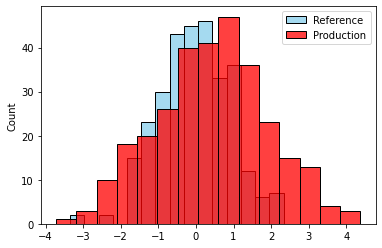

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=sample1, color="skyblue", label="Reference")
sns.histplot(data=sample2, color="red", label="Production")

plt.legend() 
plt.show()

## Same Distribution

In [ ]:
sample3 = stats.norm.rvs(size=n2, loc=0.0, scale=1.0, random_state=rng)
stats.ks_2samp(sample1, sample3)

KstestResult(statistic=0.05, pvalue=0.8483422371364409)

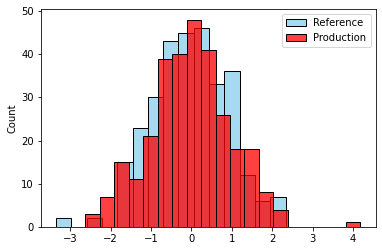

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=sample1, color="skyblue", label="Reference")
sns.histplot(data=sample3, color="red", label="Production")

plt.legend() 
plt.show()

## Chi-squared for categorical variables

In [ ]:
labels = ["Cat","Dog", "Bird", "Bear", "Snake", "Rat"]
expected = [30, 20, 45, 33, 29, 46]
observed = [12, 38, 49, 29, 15, 60]

In [ ]:
import scipy.stats as stats

#perform Chi-Square Goodness of Fit Test
stats.chisquare(f_obs=observed, f_exp=expected)

Power_divergenceResult(statistic=38.859894295276604, pvalue=2.534136271366203e-07)

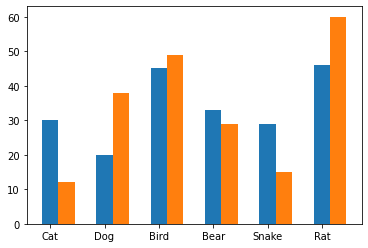

In [ ]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

width =0.3
plt.bar(np.arange(len(expected)), expected, width=width)
plt.bar(np.arange(len(observed))+ width, observed, width=width)
plt.xticks(range(len(labels)), labels)

plt.show()

In [ ]:
labels = ["Cat","Dog", "Bird", "Bear", "Snake", "Rat"]
expected = [30, 22, 45, 12, 29, 60]
observed = [28, 20, 46, 11, 31, 62]

In [ ]:
import scipy.stats as stats

#perform Chi-Square Goodness of Fit Test
stats.chisquare(f_obs=observed, f_exp=expected)

Power_divergenceResult(statistic=0.6253047718564959, pvalue=0.9868153579622351)

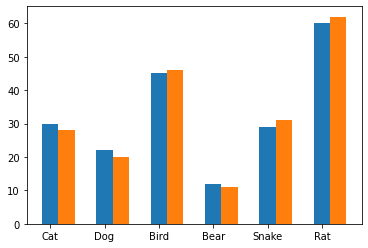

In [ ]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

width = 0.3
plt.bar(np.arange(len(expected)), expected, width=width)
plt.bar(np.arange(len(observed))+ width, observed, width=width)
plt.xticks(range(len(labels)), labels)

plt.show()

# **Session 2 - Facing the Real World**

# Installing whylogs

whylogs is made available as a Python package. You can get the latest version from PyPI with pip install whylogs:



In [ ]:
!pip install -q whylogs[viz]

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 559 kB 30.3 MB/s 
     |████████████████████████████████| 3.2 MB 40.7 MB/s 
     |████████████████████████████████| 340 kB 34.7 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 140 kB 39.4 MB/s 
     |████████████████████████████████| 1.6 MB 35.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.
gym 0.25.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.


# Loading a Pandas DataFrame


Before showing how we can log data, we first need the data itself. Let's create a simple Pandas DataFrame:

In [ ]:
import pandas as pd
data = {
    "animal": ["cat", "hawk", "snake", "cat"],
    "legs": [4, 2, 0, 4],
    "weight": [4.3, 1.8, 1.3, 4.1],
}

df = pd.DataFrame(data)

# Profiling with whylogs


To obtain a profile of your data, you can simply use whylogs' log call, and navigate through the result to a specific profile with `profile()`:

In [ ]:
import whylogs as why

profile = why.log(df).profile()

# Analyzing Profiles


Once you're done logging the data, you can generate a Profile View and inspect it in a Pandas Dataframe format:

In [ ]:
profile_view = profile.view()
prof_df = profile_view.to_pandas()

prof_df

,cardinality/est,cardinality/lower_1,cardinality/upper_1,counts/inf,counts/n,counts/nan,counts/null,distribution/max,distribution/mean,distribution/median,...,distribution/stddev,frequent_items/frequent_strings,type,types/boolean,types/fractional,types/integral,types/object,types/string,ints/max,ints/min
column,,,,,,,,,,,,,,,,,,,,,
animal,3.0,3.0,3.00015,0,4,0,0,NaN,0.000,NaN,...,0.000000,"[FrequentItem(value='cat', est=2, upper=2, low...",SummaryType.COLUMN,0,0,0,0,4,NaN,NaN
legs,3.0,3.0,3.00015,0,4,0,0,4.0,2.500,4.0,...,1.914854,"[FrequentItem(value='4', est=2, upper=2, lower...",SummaryType.COLUMN,0,0,4,0,0,4.0,0.0
weight,4.0,4.0,4.00020,0,4,0,0,4.3,2.875,4.1,...,1.545693,NaN,SummaryType.COLUMN,0,4,0,0,0,NaN,NaN


This will provide you with valuable statistics on a column (feature) basis, such as:

- Counters, such as number of samples and null values
- Inferred types, such as integral, fractional and boolean
- Estimated Cardinality
- Frequent Items
- Distribution Metrics: min,max, median, quantile values

In [ ]:
merged_profile_view = profile_view.merge(profile_view)
merged_profile_view.to_pandas()

,cardinality/est,cardinality/lower_1,cardinality/upper_1,counts/inf,counts/n,counts/nan,counts/null,distribution/max,distribution/mean,distribution/median,...,distribution/stddev,frequent_items/frequent_strings,type,types/boolean,types/fractional,types/integral,types/object,types/string,ints/max,ints/min
column,,,,,,,,,,,,,,,,,,,,,
animal,3.0,3.0,3.00015,0,8,0,0,NaN,0.000,NaN,...,0.000000,"[FrequentItem(value='cat', est=4, upper=4, low...",SummaryType.COLUMN,0,0,0,0,8,NaN,NaN
legs,3.0,3.0,3.00015,0,8,0,0,4.0,2.500,4.0,...,1.772811,"[FrequentItem(value='4', est=4, upper=4, lower...",SummaryType.COLUMN,0,0,8,0,0,4.0,0.0
weight,4.0,4.0,4.00020,0,8,0,0,4.3,2.875,4.1,...,1.431034,NaN,SummaryType.COLUMN,0,8,0,0,0,NaN,NaN


# Writing to Disk

You can also store your profile in disk for further inspection:

In [ ]:
why.write(profile,"profile.bin")

(True, 'profile.bin')

# Reading from Disk


You can read the profile back into memory with:

In [ ]:
n_prof = why.read("profile.bin")

# **Session 3 - Inspecting and Comparing Distributions with whylogs**

In this notebook, we'll show how you can use whylog's Notebook Profile Visualizer to compare two different sets of the same data. This includes:
- __Data Drift__: Detecting feature drift between two datasets' distributions
- __Data Visualization__: Comparing feature's histograms and bar charts
- __Summary Statistics__: Visualizing Summary Statistics of individual features

# Data Shift on Wine Quality

To demonstrate the Profile Visualizer, let's use [UCI's Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality), frequently
 used for learning purposes. Classification is one possible task, where we predict the wine's quality based on its features, like pH, density and percent alcohol content.

In this example, we will split the available dataset in two groups: wines with alcohol content (`alcohol` feature) below and above 11. The first group is considered our baseline (or reference) dataset, while the second will be our target dataset. The goal here is to induce a case of __Sample Selection Bias__, where the training sample is not representative of the population.

The example used here was inspired by the article [A Primer on Data Drift](https://medium.com/data-from-the-trenches/a-primer-on-data-drift-18789ef252a6). If you're interested in more information on this use case, or the theory behind Data Drift, it's a great read!

## Loading the data

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Disabling false positive warning

# this is the same data as encountered in http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
url = "https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/WineQuality/winequality-red.csv"
wine = pd.read_csv(url)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We'll split the wines in two groups. The ones with `alcohol` below 11 will form our reference sample, and the ones above 11 will form our target dataset.

In [ ]:
cond_reference = (wine['alcohol']<=11)
wine_reference = wine.loc[cond_reference]

cond_target = (wine['alcohol']>11)
wine_target = wine.loc[cond_target]

The `quality` feature is a numerical one, representing the wine's quality. Let's tranform it to a categorical feature, where each wine is classified as Good or Bad. Anything above 6.5 is a good a wine. Otherwise, it's bad.

In [ ]:
import pandas as pd

bins = (2, 6.5, 8)
group_names = ['bad', 'good']

wine_reference['quality'] = pd.cut(wine_reference['quality'], bins = bins, labels = group_names)
wine_target['quality'] = pd.cut(wine_target['quality'], bins = bins, labels = group_names)


Now, we can profile our dataframes with `whylogs`.
The `NotebookProfileVisualizer` accepts `profile_views` as arguments. Profile views are obtained from the profiles, and are used for visualization and merging purposes.

In [ ]:
import whylogs as why
result = why.log(pandas=wine_target)
prof_view = result.view()

In [ ]:
result_ref = why.log(pandas=wine_reference)
prof_view_ref = result_ref.view()

Let's instantiate `NotebookProfileVisualizer` and set the reference and target profile views:

In [ ]:
from whylogs.viz import NotebookProfileVisualizer

visualization = NotebookProfileVisualizer()
visualization.set_profiles(target_profile_view=prof_view, reference_profile_view=prof_view_ref)

Now, we're able to generate all sorts of plots and reports.
Let's take a look at some of them.

# Profile Summary

In [ ]:
visualization.profile_summary()

# Drift Summary

With `summary_drift_report`, we have overview statistics, such as number of observations and missing cells, as well as a comparison between both profile's features, with regards to each feature's distribution, and drift calculations for numerical or categorical features.

The report also displays alerts related to each of the feature's drift severity.

You can also search for a specific feature, or filter by inferred type.

In [ ]:
visualization.summary_drift_report()


The drift values are calculated in different ways, depending on the inferred type. For fractional features, the drift detection uses the quantile values and the corresponding CDFs to calculate the approximate KS statistic.For categorical features, the drift detections uses the top frequent items summary, unique count estimate and total count estimate for each feature to calculate the estimated Chi-Squared statistic.

For `alcohol`, there's an alert of severe drift, with calculated p-value of 0.00. That makes sense, since both distributions are mutually exclusive.

We can also conclude some thing just by visually inspecting the distributions. We can clearly see that the "good-to-bad" ratio changes significantly between both profiles. That in itself is a good indicator that the alcohol content might be correlated to the wine's quality

The drift value is also relevant for a number of other features. For example, the `density` also is flagged with significant drift. Let's look at this feature in particular.

# Histograms and Bar charts

Now that we have a general idea of both profiles, let's take a look at some of the individual features.

First, let's use the `double_histogram` to check on the `density` feature.

In [ ]:
visualization.double_histogram(feature_name="density")

We can visually assess that there seems to be a drift between both distributions indeed. Maybe the alcohol content plays a significant role on the wine's density.

As is the case with the alcohol content, our potential model would see density values in production never before seen in the training test. We can certainly expect performance degradation during production.

Let's check the `alcohol` feature. Obviously there's a clear separation between the distributions at the value of `11`.

In [ ]:
visualization.double_histogram(feature_name="alcohol")

In addition to the histograms, we can also plot distribution charts for categorical variables, like the `quality` feature.

In [ ]:
visualization.distribution_chart(feature_name="quality")

We can also look at the difference between distributions:

In [ ]:
visualization.difference_distribution_chart(feature_name="quality")


We can see that there is 800 or so more "bads" in the Reference profile, and 50 or so more "goods" on the target profile.

# Feature Statistics

With `feature_statistics`, we have access to very useful statistics by passing the feature and profile name:

In [ ]:
visualization.feature_statistics(feature_name="citric acid", profile="target")


Looks like we have 72 distinct values for `citric acid`, ranging from 0 to 0.79. We can also see the 10 missing values injected earlier.

## Downloading the Visualization Output


In [ ]:
import os
os.getcwd()
visualization.write(
    rendered_html=visualization.feature_statistics(
        feature_name="density", profile="target"
    ),
    html_file_name=os.getcwd() + "/example",
)

# **Session 4 - Data Validation - Ensuring Quality with Constraints**

Let's set some constraints. For example, we could expect:

1.  `volatile acidity` should never be below 0.14
2. `pH` mean should be between 3.0-3.6
3. `quality` should have only `bad` or `good` categories
4. Percentage of nulls of `density` should be below 5%

In [ ]:
from whylogs.core.constraints import ConstraintsBuilder, MetricConstraint, MetricsSelector
from whylogs.core.constraints.factories import (
    greater_than_number,
    mean_between_range,
    frequent_strings_in_reference_set,
    null_percentage_below_number,
)

In [ ]:
builder = ConstraintsBuilder(dataset_profile_view=prof_view)
builder.add_constraint(greater_than_number(column_name="volatile acidity", number=0.14))

In [ ]:
constraints = builder.build()
report = constraints.generate_constraints_report()
report

[ReportResult(name='volatile acidity greater than number 0.14', passed=0, failed=1, summary=None)]

In [ ]:
builder.add_constraint(mean_between_range(column_name="pH", lower = 3.0, upper=3.6))


In [ ]:
builder.add_constraint(null_percentage_below_number(column_name="density", number=0.05))

In [ ]:
reference_set = {"bad","good"}
builder.add_constraint(frequent_strings_in_reference_set(column_name='quality',reference_set=reference_set))

In [ ]:
constraints = builder.build()
print(constraints.validate())
print(constraints.generate_constraints_report())

False
[ReportResult(name='volatile acidity greater than number 0.14', passed=0, failed=1, summary=None), ReportResult(name='pH mean between 3.0 and 3.6 (inclusive)', passed=1, failed=0, summary=None), ReportResult(name='null percentage of density lower than 0.05', passed=1, failed=0, summary=None), ReportResult(name="quality values in set {'bad', 'good'}", passed=1, failed=0, summary=None)]


In [ ]:
visualization.constraints_report(constraints, cell_height=300)

# Reference

- https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

- https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine

- https://medium.com/data-from-the-trenches/a-primer-on-data-drift-18789ef252a6

- [Data Distribution Shifts and Monitoring](https://huyenchip.com/2022/02/07/data-distribution-shifts-and-monitoring.html)

- [Monitoring Machine Learning Systems](https://madewithml.com/courses/mlops/monitoring/)

- [Protecting Your Machine Learning Against Drift: An Introduction](https://www.youtube.com/watch?v=tL5sEaQha5o)
